# Import needed modules

In [1]:
!pip install tensorflow

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
# import data handling tools

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Data Preprocessing

**Read data and store it in dataframe**

In [3]:
import os
import pandas as pd

# Generate data paths with labels
data_dir = '/Users/trilokesh/Desktop/Weather data/dataset/'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    # Skip hidden files like .DS_Store
    if not fold.startswith('.'):
        foldpath = os.path.join(data_dir, fold)
        if os.path.isdir(foldpath):  # Ensure it's a directory
            filelist = os.listdir(foldpath)
            for file in filelist:
                fpath = os.path.join(foldpath, file)
                filepaths.append(fpath)
                labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)


In [4]:
df

,filepaths,labels
0,/Users/trilokesh/Desktop/Weather data/dataset/...,lightning
1,/Users/trilokesh/Desktop/Weather data/dataset/...,lightning
2,/Users/trilokesh/Desktop/Weather data/dataset/...,lightning
3,/Users/trilokesh/Desktop/Weather data/dataset/...,lightning
4,/Users/trilokesh/Desktop/Weather data/dataset/...,lightning
...,...,...
6857,/Users/trilokesh/Desktop/Weather data/dataset/...,snow
6858,/Users/trilokesh/Desktop/Weather data/dataset/...,snow
6859,/Users/trilokesh/Desktop/Weather data/dataset/...,snow
6860,/Users/trilokesh/Desktop/Weather data/dataset/...,snow


**Split dataframe into train, valid, and test**

In [5]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

**Create image data generator**

In [6]:
# crobed image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 5489 validated image filenames belonging to 11 classes.
Found 823 validated image filenames belonging to 11 classes.
Found 550 validated image filenames belonging to 11 classes.


**Show sample from train data**

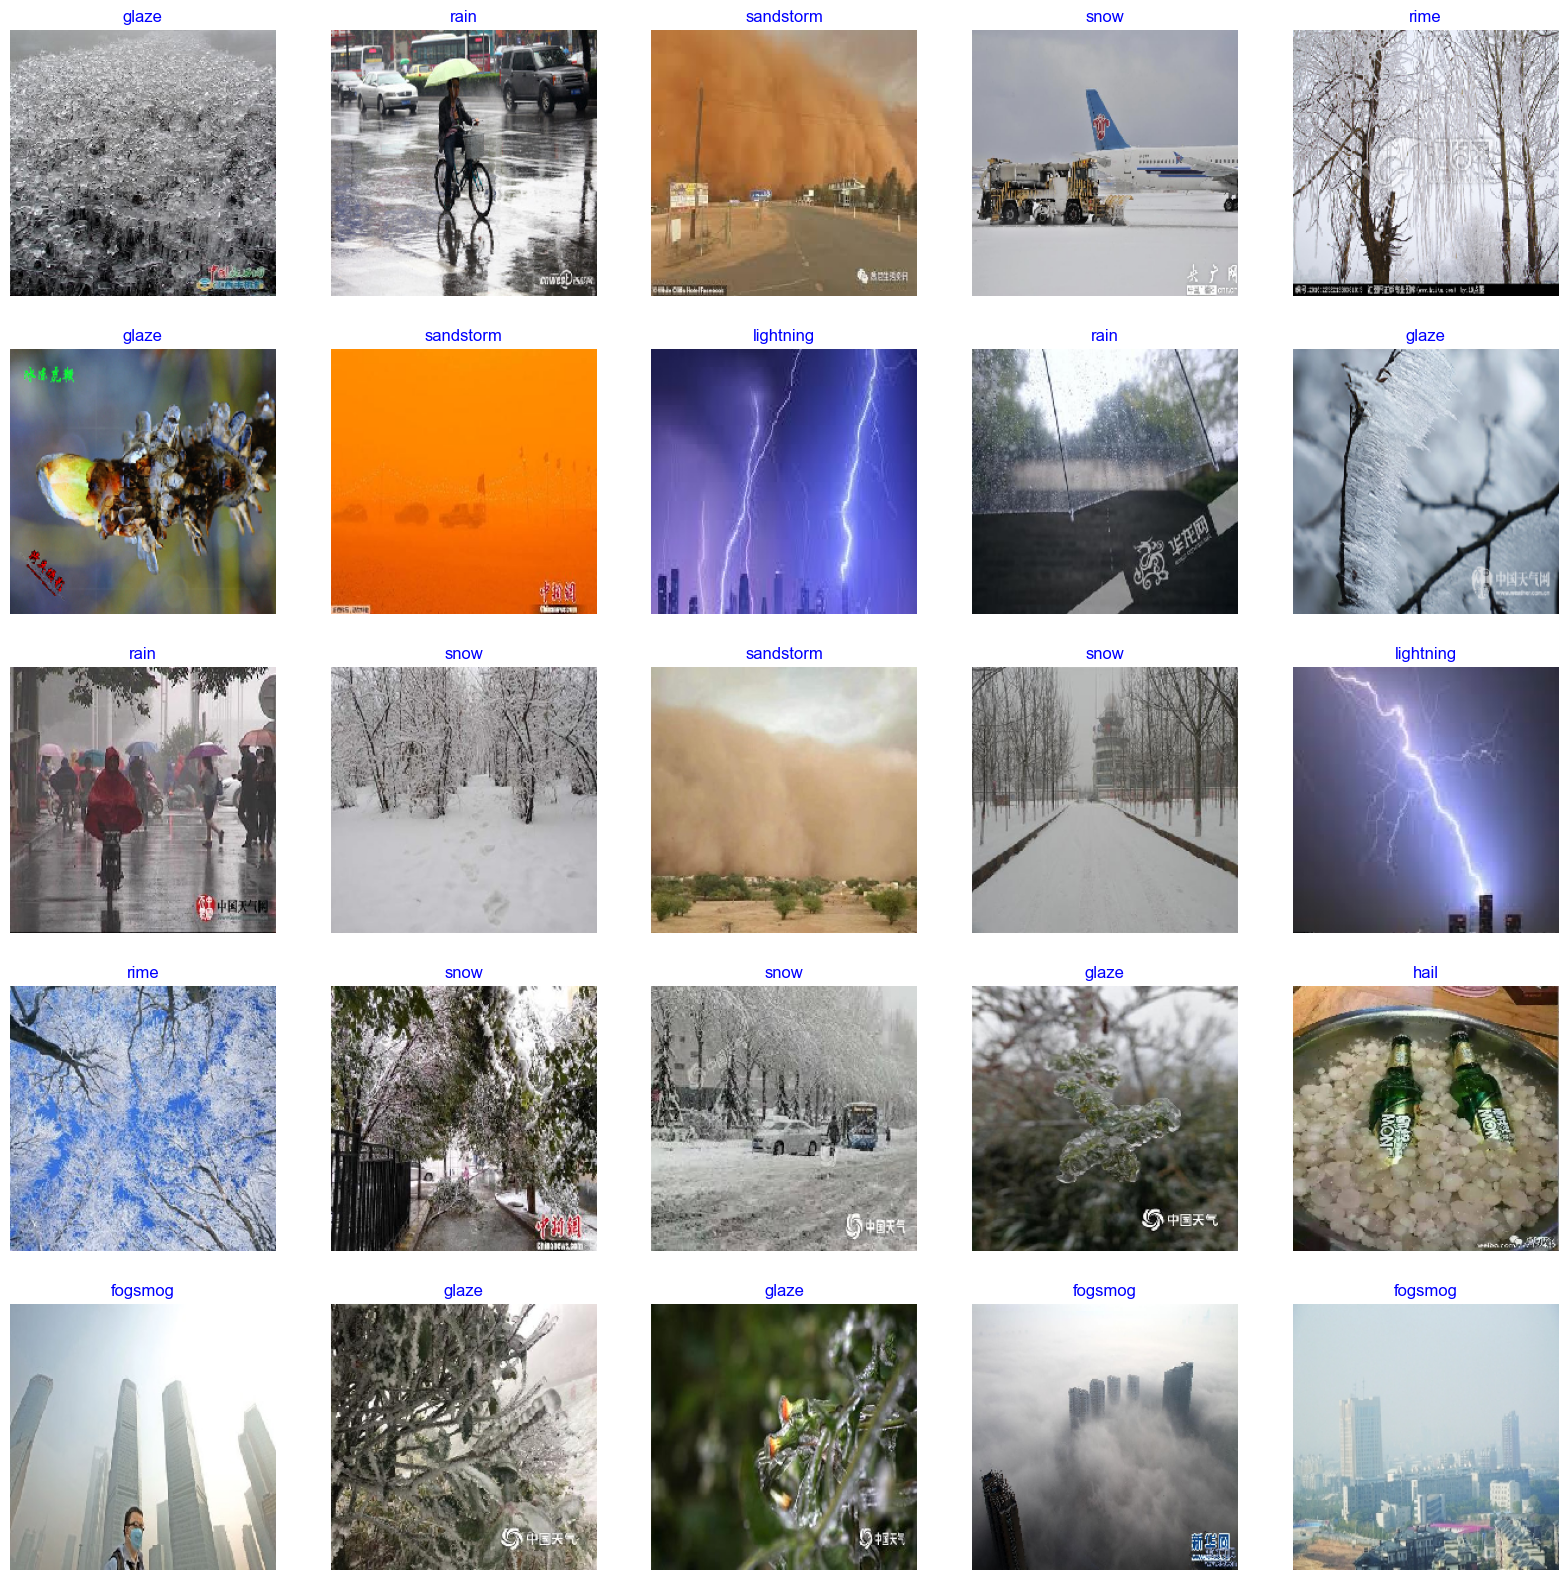

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# calculate number of displayed samples
length = len(labels)        # length of batch size
sample = min(length, 25)    # check if sample less than 25 images

plt.figure(figsize= (20, 20))
for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Model Structure

**Generic Model Creation**

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3

# Load the EfficientNetB3 model
base_model = EfficientNetB3(weights='imagenet', include_top=False)

# Count the total number of parameters in the model before freezing
total_params_before_freezing = sum(tf.reduce_prod(param.shape).numpy() for param in base_model.trainable_variables)

# Calculate the number of layers to freeze 
num_layers = len(base_model.layers)
num_layers_to_freeze = int(0.92 * num_layers)

# Freeze layers up to the calculated percentage
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Count the total number of parameters in the model after freezing
total_params_after_freezing = sum(tf.reduce_prod(param.shape).numpy() for param in base_model.trainable_variables)

# Calculate the number of frozen parameters
num_frozen_params = total_params_before_freezing - total_params_after_freezing

# Calculate the number of trainable parameters
num_trainable_params = total_params_after_freezing

# Calculate the percentage of frozen parameters
percentage_frozen_params = (num_frozen_params / total_params_before_freezing) * 100

print("Number of frozen parameters:", num_frozen_params)
print("Number of trainable parameters:", num_trainable_params)
print("Percentage of frozen parameters:", percentage_frozen_params)


Number of frozen parameters: 6819118
Number of trainable parameters: 3877114
Percentage of frozen parameters: 63.752525188309306


# Train model

In [ ]:
from tensorflow.keras.optimizers import Adam as AdamLegacy

# Compile the model using the legacy Adam optimizer
model.compile(optimizer=AdamLegacy(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
# Define the top layers for classification
top_layers = Sequential([
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(11, activation='softmax')  # Adjust the number of output classes here
])
# Combine the base model and top layers
model = Sequential([
    base_model,
    top_layers
])
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model 
history = model.fit(train_gen, validation_data=valid_gen, epochs=10, steps_per_epoch=len(train_gen), validation_steps=len(valid_gen))
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_gen, steps=test_steps)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
86/86 [==============================] - 358s 4s/step - loss: 0.5651 - accuracy: 0.8173 - val_loss: 0.3060 - val_accuracy: 0.8919
Epoch 2/10
86/86 [==============================] - 314s 4s/step - loss: 0.1880 - accuracy: 0.9377 - val_loss: 0.3129 - val_accuracy: 0.8991
Epoch 3/10
86/86 [==============================] - 318s 4s/step - loss: 0.1188 - accuracy: 0.9603 - val_loss: 0.3638 - val_accuracy: 0.9040
Epoch 4/10
86/86 [==============================] - 323s 4s/step - loss: 0.0780 - accuracy: 0.9750 - val_loss: 0.4053 - val_accuracy: 0.8979
Epoch 5/10
86/86 [==============================] - 325s 4s/step - loss: 0.0656 - accuracy: 0.9772 - val_loss: 0.3894 - val_accuracy: 0.9113
Epoch 6/10
86/86 [==============================] - 662s 8s/step - loss: 0.0565 - accuracy: 0.9809 - val_loss: 0.5249 - val_accuracy: 0.8882
Epoch 7/10
86/86 [==============================] - 204s 2s/step - loss: 0.0489 - accuracy: 0.9863 - val_loss: 0.4008 - val_accuracy: 0.9077
Epoch 8/10
86

In [10]:
# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, None, None, 1536   10783535  
 )                           )                                   
                                                                 
 sequential (Sequential)     (None, 11)                396299    
                                                                 
Total params: 11179834 (42.65 MB)
Trainable params: 4273413 (16.30 MB)
Non-trainable params: 6906421 (26.35 MB)
_________________________________________________________________


**Display model performance**

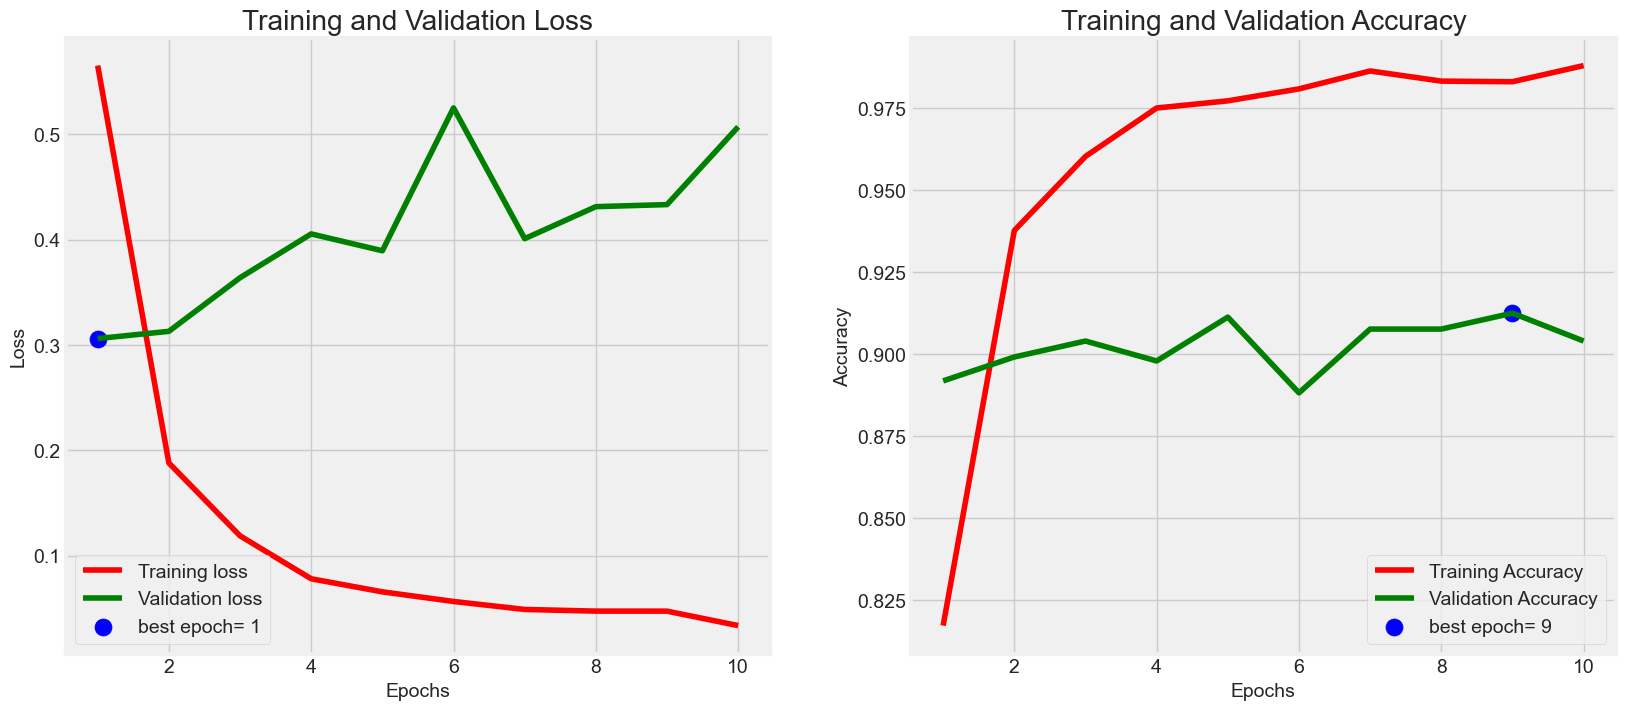

In [11]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Evaluate model

In [12]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

10/10 [==============================] - 13s 1s/step - loss: 0.4458 - accuracy: 0.9055
Train Loss:  0.018087683245539665
Train Accuracy:  0.9937499761581421
--------------------
Validation Loss:  0.5682690739631653
Validation Accuracy:  0.895312488079071
--------------------
Test Loss:  0.44575566053390503
Test Accuracy:  0.9054545164108276


**Get Predictions**

In [13]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

**Confusion Matrics and Classification Report**

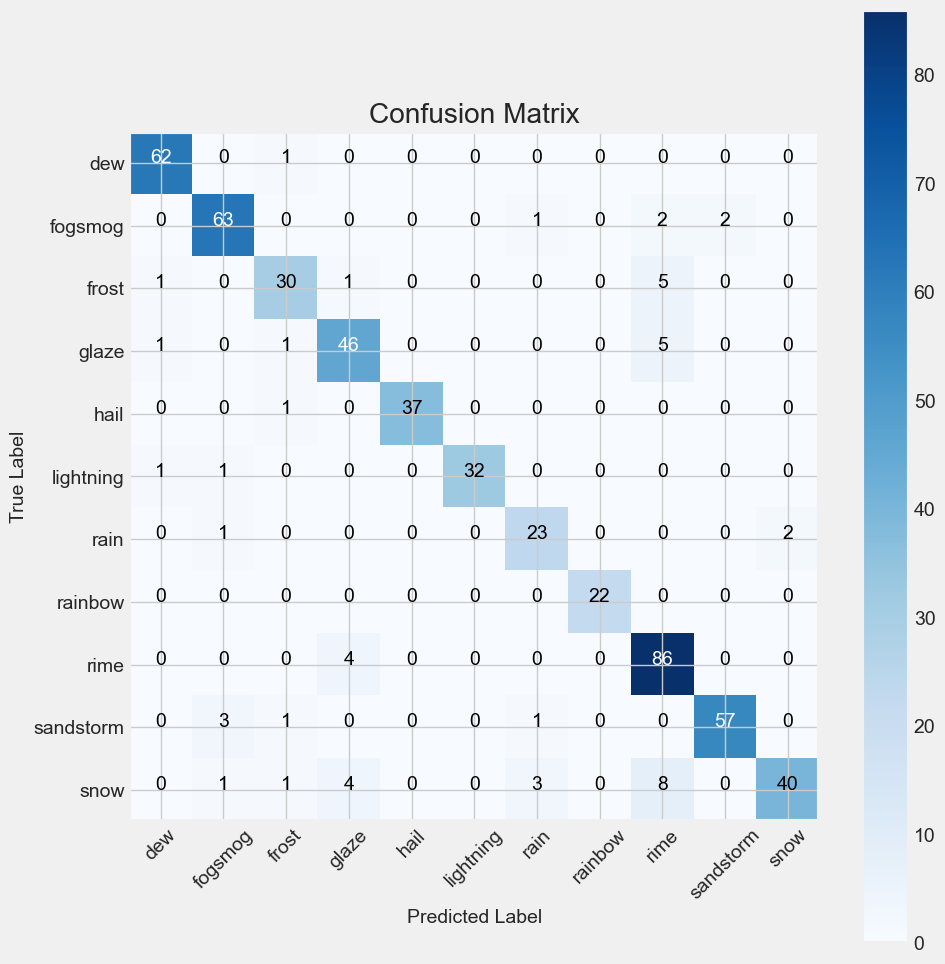

In [14]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [15]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

         dew       0.95      0.98      0.97        63
     fogsmog       0.91      0.93      0.92        68
       frost       0.86      0.81      0.83        37
       glaze       0.84      0.87      0.85        53
        hail       1.00      0.97      0.99        38
   lightning       1.00      0.94      0.97        34
        rain       0.82      0.88      0.85        26
     rainbow       1.00      1.00      1.00        22
        rime       0.81      0.96      0.88        90
   sandstorm       0.97      0.92      0.94        62
        snow       0.95      0.70      0.81        57

    accuracy                           0.91       550
   macro avg       0.92      0.91      0.91       550
weighted avg       0.91      0.91      0.90       550



**Save model**

In [16]:
# Define the file path where you want to save the model
model_path = 'Trilokesh_Weather_Model.h5'

# Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)

Model saved successfully at: Trilokesh_Weather_Model.h5


# Prediction using loaded_model

In [17]:
loaded_model = tf.keras.models.load_model('Trilokesh_Weather_Model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [19]:
image_path = '/Users/trilokesh/Desktop/Weather data/dataset/frost/3601.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 53ms/step
frost
